In [1]:
# 导入相关的库
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

train_csv=pd.read_csv("train.csv")
test_csv=pd.read_csv("test.csv")

In [6]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [2]:
from sklearn.ensemble import RandomForestRegressor

def set_missing_ages(df):
    # 把已有数值特征取出来丢进Random Forest Regressor（随机森林回归）中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
    # 乘客分成一直年龄和未知年龄两部分
    know_age = age_df[age_df.Age.notnull()].values
    unknow_age = age_df[age_df.Age.isnull()].values
    
    # y即目标年龄
    y = know_age[:,0]
    # x即特征属性值
    x = know_age[:,1:]
    # fit到RandomForestRegressor之中
    # 构建随机森林模型
    rfr = RandomForestRegressor(random_state=0,n_estimators=2000,n_jobs=-1)
    rfr.fit(x,y)
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknow_age[:,1:])
    #print("predictedAges",predictedAges)
    # 用得到的预测结果填补原缺失数据
    for i in range(len(predictedAges)):
        predictedAges[i] = int(predictedAges[i])
    df.loc[(df.Age.isnull()),'Age'] = predictedAges
    return df,rfr

# 建立一个函数，将有无Cabin'处理数据
def set_Cabin_type(df):
    df.loc[(df.Cabin.notnull()),'Cabin']="Yes"
    df.loc[(df.Cabin.isnull()),'Cabin']="No"
    return df

train=pd.read_csv('train.csv')
train,rfr = set_missing_ages(train)
train = set_Cabin_type(train)

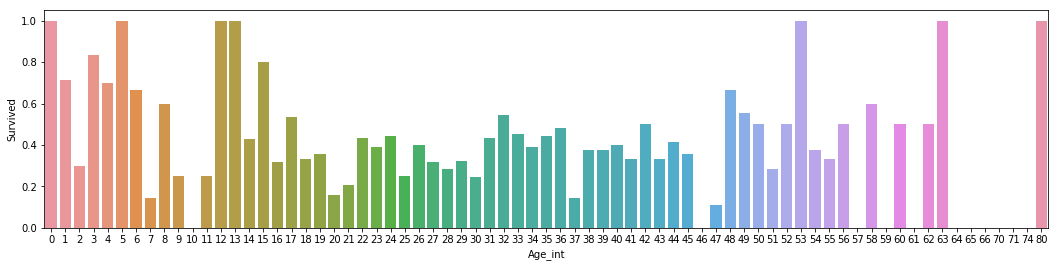

In [3]:
# 不同年龄下的平均生存率
fig,axis1 = plt.subplots(1,1,figsize=(18,4))
train["Age_int"]=train["Age"].astype(int)
average_age = train[["Age_int","Survived"]].groupby(["Age_int"],as_index=False).mean()
sns.barplot(x='Age_int',y='Survived',data=average_age)


In [4]:
#年龄特征分类
train['Age']=train['Age'].map(lambda x: 'child' if x<10 else 'youth' if x<18 else 'youth' if x<30 else 'adlut' if x<46 else 'adlut' if x<60 else 'old' if x<75 else 'tooold' if x>=75 else 'null')


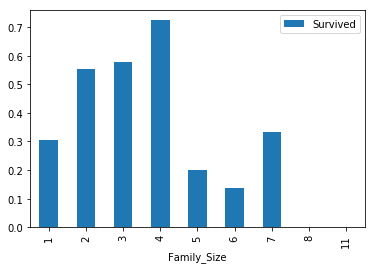

In [5]:
# 看亲友的数量与存活率之间的关系
train['Family_Size'] = train['Parch'] + train['SibSp'] + 1
train[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()
train['Family_Size'] = train['Family_Size'].map(lambda x:'small' if x<2 else 'mid' if x<5 else 'big' if x<8 else 'bigger' if x>=8 else 'null')


In [6]:
# 将兄弟姐妹和配偶的数量特征分类
train['SibSp']=train['SibSp'].map(lambda x: 'small' if x<1 else 'middle' if x<3 else 'large')

# 将有无小孩父母特征分类
train['Parch']=train['Parch'].map(lambda x: 'small' if x<1 else 'middle' if x<4 else 'large')


In [7]:
# 将船费特征分类
train['Fare']=train['Fare'].map(lambda x: 'poor' if x<2.5 else 'rich')


In [8]:
#有编号的的为yes,没有的为no
train['Cabin']=train['Cabin'].map(lambda x:'yes' if type(x)==str else 'no')

In [9]:
# 对于名字提取名称呼
train['Title'] = train['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])


In [10]:
# 将各式称呼进行统一化处理：

title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

train['Title'] = train['Title'].map(title_Dict)

In [17]:
# 导出处理好的数据
#train.to_csv("deal_with_train.csv")

In [11]:
#将训练数据分成标记和特征两部分
labels= train['Survived']
# 删掉不需要的数据
features= train.drop(['Survived','PassengerId','Name','Ticket','Age_int'],axis=1)

In [12]:
#对所有特征实现独热编码
features = pd.get_dummies(features)
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

30 total features after one-hot encoding.


## 处理测试数据

In [13]:
# 好了，现在训练集的数据已经整理好了，我们现在同法处理测试集的数据：
# 重写补全age
test=pd.read_csv('test.csv')
def set_missing_ages_test(df,rfr):
    # 把已有数值特征取出来丢进Random Forest Regressor（随机森林回归）中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
    # 乘客分成一直年龄和未知年龄两部分
    know_age = age_df[age_df.Age.notnull()].values
    unknow_age = age_df[age_df.Age.isnull()].values
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknow_age[:,1:])
    #print("predictedAges",predictedAges)
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.Age.isnull()),'Age'] = predictedAges
    return df
test = set_missing_ages_test(test,rfr)

In [14]:
test = set_Cabin_type(test)
#年龄特征分类
test['Age']=test['Age'].map(lambda x: 'child' if x<10 else 'youth' if x<18 else 'youth' if x<30 else 'adlut' if x<46 else 'adlut' if x<60 else 'old' if x<75 else 'tooold' if x>=75 else 'null')
# 看亲友的数量与存活率之间的关系
test['Family_Size'] = test['Parch'] + test['SibSp'] + 1
#test[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()
test['Family_Size'] = test['Family_Size'].map(lambda x:'small' if x<2 else 'mid' if x<5 else 'big' if x<8 else 'bigger' if x>=8 else 'null')

# 将兄弟姐妹和配偶的数量特征分类
test['SibSp']=test['SibSp'].map(lambda x: 'small' if x<1 else 'middle' if x<3 else 'large')

# 将有无小孩父母特征分类
test['Parch']=test['Parch'].map(lambda x: 'small' if x<1 else 'middle' if x<4 else 'large')
# 将船费特征分类
test['Fare']=test['Fare'].map(lambda x: 'poor' if x<2.5 else 'rich')
#有编号的的为yes,没有的为no
test['Cabin']=test['Cabin'].map(lambda x:'yes' if type(x)==str else 'no')
# 对于名字提取名称呼
test['Title'] = test['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
test['Title'] = test['Title'].map(title_Dict)


In [22]:
# 将test数据导出
#test.to_csv('deal_with_test.csv')

In [15]:
PassengerId=test['PassengerId']
#删除不需要的特征并进行独热编码
test=test.drop(['PassengerId','Name','Ticket'],axis=1)
test=pd.get_dummies(test)
encoded = list(test.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

30 total features after one-hot encoding.


In [16]:
# 导入相关的库
#首先引入需要的库和函数
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,roc_auc_score
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [17]:
print(features)
print(labels)

     Pclass  Sex_female  Sex_male  Age_adlut  Age_child  Age_old  Age_tooold  \
0         3           0         1          0          0        0           0   
1         1           1         0          1          0        0           0   
2         3           1         0          0          0        0           0   
3         1           1         0          1          0        0           0   
4         3           0         1          1          0        0           0   
..      ...         ...       ...        ...        ...      ...         ...   
886       2           0         1          0          0        0           0   
887       1           1         0          0          0        0           0   
888       3           1         0          0          0        0           0   
889       1           0         1          0          0        0           0   
890       3           0         1          1          0        0           0   

     Age_youth  SibSp_large  SibSp_midd

In [25]:
# 定义通用函数框架(通过训练数据，得到模型)
def fit_model(alg,parameters):
    x = features
    y = labels # 由于数据较少，使用全部数据进行网格搜索
    scorer=make_scorer(roc_auc_score)  #使用roc_auc_score作为评分标准
    grid = GridSearchCV(alg,parameters,scoring=scorer,cv=5)##使用网格搜索，出入参数
    start = time() # 计时
    grid = grid.fit(x,y) # 模型训练
    end = time() 
    t = round(end-start,3)
    print (grid.best_params_)  #输出最佳参数
    print ('searching time for {} is {} s'.format(alg.__class__.__name__,t)) #输出搜索时间
    return grid #返回训练好的模型

In [26]:
# 定义初始化函数
## 列出需要使用的算法
#列出需要使用的算法
alg1=DecisionTreeClassifier(random_state=29)
alg2=SVC(probability=True,random_state=29)  #由于使用roc_auc_score作为评分标准，需将SVC中的probability参数设置为True
alg3=RandomForestClassifier(random_state=29)
alg4=AdaBoostClassifier(random_state=29)
alg5=KNeighborsClassifier(n_jobs=-1)
#alg6=XGBClassifier(random_state=29,n_jobs=-1)

In [27]:
# 然后列出我们需要调整的参数及取值范围，这是一个很繁琐的工作，需要大量的尝试和优化。（以下参数范围并非最优，大家可以继续探索）
#列出需要调整的参数范围
parameters1={'max_depth':range(1,10),'min_samples_split':range(2,10)}
parameters2 = {"C":range(1,20), "gamma": [0.05,0.1,0.15,0.2,0.25]}
parameters3_1 = {'n_estimators':range(10,200,10)}
parameters3_2 = {'max_depth':range(1,10),'min_samples_split':range(2,10)}  #搜索空间太大，分两次调整参数
parameters4 = {'n_estimators':range(10,200,10),'learning_rate':[i/10.0 for i in range(5,15)]}
parameters5 = {'n_neighbors':range(2,10),'leaf_size':range(10,80,20)  }
parameters6_1 = {'n_estimators':range(10,200,10)}
parameters6_2 = {'max_depth':range(1,10),'min_child_weight':range(1,10)}
parameters6_3 = {'subsample':[i/10.0 for i in range(1,10)], 'colsample_bytree':[i/10.0 for i in range(1,10)]}#搜索空间太大，分三次调整参数


In [ ]:
# 1、DecisonTreeClassifier
clf1 = fit_model(alg1,parameters1)

# 2、SVM
clf2 = fit_model(alg2,parameters2)

# 3.RandomForest
clf3_m1=fit_model(alg3,parameters3_1)

# 3.1第二次调参
alg3=RandomForestClassifier(random_state=29,n_estimators=180)
clf3=fit_model(alg3,parameters3_2)

clf4=fit_model(alg4,parameters4)

# 5、KNN
clf5=fit_model(alg5,parameters5)

{'max_depth': 4, 'min_samples_split': 2}
searching time for DecisionTreeClassifier is 1.46 s
{'C': 1, 'gamma': 0.15}
searching time for SVC is 36.853 s
{'n_estimators': 90}
searching time for RandomForestClassifier is 9.282 s
{'max_depth': 5, 'min_samples_split': 3}
searching time for RandomForestClassifier is 52.668 s


In [29]:
#首先我们先定义一个保存函数，将预测的结果保存为可以提交的格式：
def save(clf,i):
    pred=clf.predict(test)
    sub=pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': pred })
    sub.to_csv("res_tan_{}.csv".format(i), index=False)

# 调用这个函数，完成6个模型的预测：
i=1
for clf in [clf1,clf2,clf3,clf4,clf5]:
    save(clf,i)
    i=i+1